In [1]:
# from utils.graph_utils import relation_pos,score_weights
# from DB.connection import connection

class score_graph():

    def __init__(self,fsid):
        self.fsid = fsid

    def total_nodes(self, with_relation):
        nodes = []
        for i in with_relation:
            nodes.append(i[0])
            nodes.append(i[1])
        nodes = set(nodes)
        return nodes

    def total_nodes_with_pos(self,with_relation_with_pos):
        nodes_with_pos = {}
        for nodes_rel in with_relation_with_pos:
            for node in with_relation_with_pos[nodes_rel]:
                node_pos = [i['pos'] for i in node]
                node_text = " ".join([i['word'] for i in node])
                nodes_with_pos[node_text] = node_pos
        return nodes_with_pos

    def replace_mention_with_representative(self,output,text, start_index, sentence_count):
        #     print (text,start_index,sentence_count)
        for coref in output['corefs']:
            coref_result = output['corefs'][coref]
            for mention in coref_result:
                coref_text = mention['text']
                coref_start_index = mention['startIndex'] - 1
                coref_sentence_count = mention['sentNum']
                if sentence_count == coref_sentence_count:
                    print("ORIGINAL->",text,start_index,sentence_count)
                    #                 print (start_index,coref_start_index)
                    if start_index == coref_start_index:
                        #                     print("ORIGINAL->",text,start_index,sentence_count)
                        #                     print ("COREF->",coref_text,coref_start_index,coref_sentence_count)
                        #                     print ("MENTION->",coref_result)
                        for representative in coref_result:
                            if representative['isRepresentativeMention'] == True:
                                rep_text = representative['text']
                                rep_start_index = representative['startIndex'] - 1
                                rep_sentence_count = representative['sentNum']
                                print ("REPRESENTATIVE->",rep_text,rep_start_index,rep_sentence_count)
                                return [rep_text, rep_start_index, rep_sentence_count]



    def preprocess_on_stanford_NER(self,output):

        ie_entities_with_labels = {}
        non_human_ents = []
        total_ents = []
        sentence_count = 0
        human_and_date_ents = []
        raw_entities = []
        for i in output['sentences']:
            print("============================================================>>>>>")
            sentence_count = sentence_count + 1
            for j in i['entitymentions']:
                text = j['text']
                start_index = j['tokenBegin']
                # GET REPRESENTATIVE OF EACH WORD AND REPLACE REFRENCE WORD FROM ITS REPRESENTATIVE IF THERE
                result = self.replace_mention_with_representative(output,text, start_index, sentence_count)
                raw_entities.append(text)
                if j['ner'] != 'DURATION' and j['ner'] != 'DATE' and j['ner'] != 'PERSON':
                    ie_entities_with_labels[j['text']] = j['ner']
                    if result:
                        print ("NER GOT REPLACED BY")
                        print(text, "==>", result[0])

                        coref_text = result[0]
                        coref_start_index = result[1]
                        coref_sentence_count = result[2]

                        total_ents.append([coref_text, coref_start_index, coref_sentence_count])
                        non_human_ents.append([coref_text, coref_start_index, coref_sentence_count])

                    else:
                        total_ents.append([text, start_index, sentence_count])
                        non_human_ents.append([text, start_index, sentence_count])
                else:
                    if result:
                        print ("NER GOT REPLACED BY")
                        print(text, "==>", result[0])
                        coref_text = result[0]
                        coref_start_index = result[1]
                        coref_sentence_count = result[2]
                        total_ents.append([coref_text, coref_start_index, coref_sentence_count])
                        human_and_date_ents.append([coref_text, coref_start_index, coref_sentence_count])
                    else:
                        total_ents.append([text, start_index, sentence_count])
                        human_and_date_ents.append([text, start_index, sentence_count])

        non_human_ents = list(set([i[0] for i in non_human_ents]))
        human_and_date_ents = list(set([i[0] for i in human_and_date_ents]))
        total_ents = list(set([i[0] for i in total_ents]))
        return non_human_ents,human_and_date_ents,total_ents,raw_entities

    def score_non_person_nodes(self,non_human_ents, nodes, score):
        entities_not_recognized = []
        recognized_entites = []
        for i in non_human_ents:
            try:
                int(i)
                recognized = False
                # IF ANY INTEGER COMES, CHECK IF THAT INT IN ANYWHERE IN PHRASE
                #             print ("INTEGER->",i)
                for ie in nodes:
                    if i in ie:
                        recognized = True
                        recognized_entites.append(i)
                        break

                if not recognized:
                    entities_not_recognized.append(i)

            except ValueError:

                if i not in nodes:
                    entities_not_recognized.append(i)
                else:
                    recognized_entites.append(i)
        if non_human_ents:
            score = score - (len(entities_not_recognized) / len(non_human_ents))
        else:
            score = 0
        print ("score_non_person_nodes -> RECOGNIZED ENTITIES->",recognized_entites)
        print ("score_non_person_nodes -> ENTITIES NOT RECOGNIZED->",entities_not_recognized)
        return score

    def scoring_persona_and_duration_nodes(self,human_and_date_ents, nodes, score):
        entities_not_recognized = []
        recognized_entites = []
        for ents in human_and_date_ents:
            if ents in nodes:
                recognized_entites.append(ents)
            else:
                entities_not_recognized.append(ents)
        if human_and_date_ents:
            score = score - (len(entities_not_recognized) / len(human_and_date_ents))
        else:
            score = 0
        print("scoring_persona_and_duration_nodes -> RECOGNIZED ENTITIES->", recognized_entites)
        print("scoring_persona_and_duration_nodes -> ENTITIES NOT RECOGNIZED->", entities_not_recognized)
        return score

    def score_relation_words_in_nodes(self,nodes_with_pos, score,nodes):
        num_of_nodes_incorrect = []
        for node in nodes_with_pos:
            phrase_pos = nodes_with_pos[node]
            for pos in phrase_pos:
                if pos in relation_pos:
                    num_of_nodes_incorrect.append(node)
                    break
        if nodes:
            score = score - len(num_of_nodes_incorrect) / len(nodes)
        else:
            score = 0
        return score

    def get_largest_connection(self,num_of_connected_comps):
        print ("num_of_connected_comps",num_of_connected_comps)
        if num_of_connected_comps:
            maxLength = max(len(x) for x in num_of_connected_comps)
            largest_lis = None
            disconnected_lis = []
            for lis in num_of_connected_comps:
                if len(lis) == maxLength:
                    largest_lis = lis
                else:
                    disconnected_lis.append(lis)
        else:
            largest_lis = []
            disconnected_lis = []
        return largest_lis, disconnected_lis

    def score_disconnected_graph(self,disconnected_conn, nodes, score):
        print ("score_disconnected_graph->",disconnected_conn,nodes,score)
        cummulative_score_of_disconnected_graph = []
        if nodes:
            if disconnected_conn:
                for dis in disconnected_conn:
                    cummulative_score_of_disconnected_graph.append(len(dis) / len(nodes))
                score = score - sum(cummulative_score_of_disconnected_graph)
            else:
                score = 1
        else:
            score = 0
        return score

    def get_weighted_score(self,non_person_nodes_score,person_and_date_score,relation_word_in_node_score,distribute_graph_score):
        print ("SCORES-->")
        print (non_person_nodes_score,person_and_date_score,relation_word_in_node_score,distribute_graph_score)
        all_scores = [non_person_nodes_score,person_and_date_score,relation_word_in_node_score,distribute_graph_score]
        weight = 1/len(all_scores)
        weighted_score = [i * weight for i in all_scores]
        weighted_average_score = sum(weighted_score)/1
        return weighted_average_score


    def calling_all_functions(self,output,with_relation,with_relation_with_pos,num_of_connected_comps):
        try:
            nodes = self.total_nodes(with_relation)
            print ('TOTAL NODES',nodes)
            nodes_with_pos = self.total_nodes_with_pos(with_relation_with_pos)
            print ("NODES WITH POS",nodes_with_pos)
            non_human_ents,human_and_date_ents,total_ents,raw_entities = self.preprocess_on_stanford_NER(output)
            print ("NON HUMAN ENTS->",non_human_ents)
            print ("HUMAN AND DATE ENTS->",human_and_date_ents)
            print ("TOTAL ENTS->",total_ents)
            print ("RAW ENTS->",raw_entities)
            non_person_nodes_score = self.score_non_person_nodes(non_human_ents,nodes,score = 1)
            print ("NON PERSON NODES SCORE->",non_person_nodes_score)
            person_and_date_score = self.scoring_persona_and_duration_nodes(human_and_date_ents,nodes,score=1)
            print ("PERSON AND DATE SCORE",person_and_date_score)
            relation_word_in_node_score = self.score_relation_words_in_nodes(nodes_with_pos,1,nodes)
            print ("RELATION WORD IN NODE SCORE",relation_word_in_node_score)
            print ("NUM OF CONNECTED COMSPS->",num_of_connected_comps)
            largest_component,disconnected_components = self.get_largest_connection(num_of_connected_comps)
            print ("LARGEST COMPONENT->",largest_component,len(largest_component))
            print ("DISCONNECTED COMPS->",disconnected_components)
            distribute_graph_score = self.score_disconnected_graph(disconnected_components,nodes,score=1)
            print ("DISTRIBUTED GRAPH SCORE->",distribute_graph_score)
            quality_score = self.get_weighted_score(non_person_nodes_score,person_and_date_score,relation_word_in_node_score,distribute_graph_score)
            print ("QUALITY SCORE->",quality_score)
            if not quality_score:
                quality_score = 0
            quality_score_status = connection.populate_quality_score(self.fsid,quality_score)
            connection.sess.commit()
            return quality_score_status
        except Exception as e:
            print ("UNKNOW EXCEPTION IN CREATING QUALITY SCORE")
            return {'status':500,'body':"UNKNOW EXCEPTION IN CREATING QUALITY SCORE-> {}".format(e.args[0])}


In [152]:
import spacy
# import neuralcoref
import nltk
from pycorenlp import *
corenlp=StanfordCoreNLP("http://localhost:9000/")
import collections
import os
import numpy as np 
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib import pylab
from matplotlib import pylab
import networkx as nx
import json
import time

In [153]:
# utils --> graph_utils.py

relation_pos = ['VB','VBD','VBG','VBN','VBP','VBZ','JJ','JJR','JJS','RB','RBR','RBS','IN','DT']
noun_pos = ['NN','NNP','NNPS','NNS','PRP','PRP$']
prp_nouns = ['PRP','PRP$']
score_weights = {'non_person_nodes':0.25,'person_nodes':0.25,'relation_words_in_node':0.25,'distributed_graph':0.25}
annotators = "coref,tokenize,openie,coref.mention"

def get_tags(output):
    pos_tags = {}
    for sentence in range(len(output["sentences"])):
        for word in output["sentences"][sentence]['tokens']:
            pos_tags[word['originalText']] = word['pos']
    return pos_tags


def get_ie(output):
    for sentence in output['sentences']:
        print ("===========================================================================>>>>>>>>>>>>>>>>")
        for i in range(len(sentence['openie'])):
            relation_sentence = (sentence['openie'][i]['subject'],sentence['openie'][i]['relation'],sentence['openie'][i]['object'])
            print (relation_sentence)

In [154]:
annotators = "coref,tokenize,openie,ner,coref.mention"
properties = {"annotators": annotators,
                      "outputFormat": "json"
            , 'openie.triple.strict': 'true'
                      }

In [155]:
# text = "I have had Kidney disease for 20 yrs and am now stage 5, end life. Will be getting dialysis soon with hip replacements if I can ever get to a hospital again."
text = "I was diagnosed with CHF in 2018 and my options were to die, heart transplant or heart pump...in no order. I started my fundraiser to make people aware of the good that can come from the research that's been done and to show that you can with a change in diet, exercise and meditation & maintain a great lifestyle."
tokens_with_pos_all_sentences = []
output = None
pos_tags = None

In [156]:
output = json.loads(corenlp.annotate(text, properties))

In [157]:
output

{'sentences': [{'index': 0,
   'basicDependencies': [{'dep': 'ROOT',
     'governor': 0,
     'governorGloss': 'ROOT',
     'dependent': 3,
     'dependentGloss': 'diagnosed'},
    {'dep': 'nsubj:pass',
     'governor': 3,
     'governorGloss': 'diagnosed',
     'dependent': 1,
     'dependentGloss': 'I'},
    {'dep': 'aux:pass',
     'governor': 3,
     'governorGloss': 'diagnosed',
     'dependent': 2,
     'dependentGloss': 'was'},
    {'dep': 'case',
     'governor': 5,
     'governorGloss': 'CHF',
     'dependent': 4,
     'dependentGloss': 'with'},
    {'dep': 'obl',
     'governor': 3,
     'governorGloss': 'diagnosed',
     'dependent': 5,
     'dependentGloss': 'CHF'},
    {'dep': 'case',
     'governor': 7,
     'governorGloss': '2018',
     'dependent': 6,
     'dependentGloss': 'in'},
    {'dep': 'obl',
     'governor': 3,
     'governorGloss': 'diagnosed',
     'dependent': 7,
     'dependentGloss': '2018'},
    {'dep': 'cc',
     'governor': 13,
     'governorGloss': 'die

In [158]:
output['sentences'][0]['entitymentions']

[{'docTokenBegin': 6,
  'docTokenEnd': 7,
  'tokenBegin': 6,
  'tokenEnd': 7,
  'text': '2018',
  'characterOffsetBegin': 28,
  'characterOffsetEnd': 32,
  'ner': 'DATE',
  'normalizedNER': '2018',
  'nerConfidences': {'DATE': 0.99621779711387},
  'timex': {'tid': 't1', 'type': 'DATE', 'value': '2018'}}]

In [159]:
o1 = output
o1

{'sentences': [{'index': 0,
   'basicDependencies': [{'dep': 'ROOT',
     'governor': 0,
     'governorGloss': 'ROOT',
     'dependent': 3,
     'dependentGloss': 'diagnosed'},
    {'dep': 'nsubj:pass',
     'governor': 3,
     'governorGloss': 'diagnosed',
     'dependent': 1,
     'dependentGloss': 'I'},
    {'dep': 'aux:pass',
     'governor': 3,
     'governorGloss': 'diagnosed',
     'dependent': 2,
     'dependentGloss': 'was'},
    {'dep': 'case',
     'governor': 5,
     'governorGloss': 'CHF',
     'dependent': 4,
     'dependentGloss': 'with'},
    {'dep': 'obl',
     'governor': 3,
     'governorGloss': 'diagnosed',
     'dependent': 5,
     'dependentGloss': 'CHF'},
    {'dep': 'case',
     'governor': 7,
     'governorGloss': '2018',
     'dependent': 6,
     'dependentGloss': 'in'},
    {'dep': 'obl',
     'governor': 3,
     'governorGloss': 'diagnosed',
     'dependent': 7,
     'dependentGloss': '2018'},
    {'dep': 'cc',
     'governor': 13,
     'governorGloss': 'die

In [160]:
emn0 = [{'tokenBegin': 4,
  'tokenEnd': 5,
  'text': 'CHF',
  'characterOffsetBegin': 21,
  'characterOffsetEnd': 24,
  'ner': 'DISEASE'},
 {'tokenBegin': 6,
  'tokenEnd': 7,
  'text': '2018',
  'characterOffsetBegin': 28,
  'characterOffsetEnd': 32,
  'ner': 'TIME'},
 {'tokenBegin': 14,
  'tokenEnd': 16,
  'text': 'heart transplant',
  'characterOffsetBegin': 61,
  'characterOffsetEnd': 77,
  'ner': 'TREATMENT'},
 {'tokenBegin': 17,
  'tokenEnd': 19,
  'text': 'heart pump',
  'characterOffsetBegin': 81,
  'characterOffsetEnd': 91,
  'ner': 'OBJECT'}]

In [161]:
emn1 = [{'tokenBegin': 4,
  'tokenEnd': 5,
  'text': 'CHF',
  'characterOffsetBegin': 21,
  'characterOffsetEnd': 24,
  'ner': 'DISEASE'},
 {'tokenBegin': 6,
  'tokenEnd': 7,
  'text': '2018',
  'characterOffsetBegin': 28,
  'characterOffsetEnd': 32,
  'ner': 'TIME'},
 {'tokenBegin': 14,
  'tokenEnd': 16,
  'text': 'heart transplant',
  'characterOffsetBegin': 61,
  'characterOffsetEnd': 77,
  'ner': 'TREATMENT'},
 {'tokenBegin': 17,
  'tokenEnd': 19,
  'text': 'heart pump',
  'characterOffsetBegin': 81,
  'characterOffsetEnd': 91,
  'ner': 'OBJECT'}]

In [162]:
o1['sentences'][0]['entitymentions'] = emn0
o1['sentences'][1]['entitymentions'] = emn1

In [163]:
o1['sentences'][1]['entitymentions']

[{'tokenBegin': 4,
  'tokenEnd': 5,
  'text': 'CHF',
  'characterOffsetBegin': 21,
  'characterOffsetEnd': 24,
  'ner': 'DISEASE'},
 {'tokenBegin': 6,
  'tokenEnd': 7,
  'text': '2018',
  'characterOffsetBegin': 28,
  'characterOffsetEnd': 32,
  'ner': 'TIME'},
 {'tokenBegin': 14,
  'tokenEnd': 16,
  'text': 'heart transplant',
  'characterOffsetBegin': 61,
  'characterOffsetEnd': 77,
  'ner': 'TREATMENT'},
 {'tokenBegin': 17,
  'tokenEnd': 19,
  'text': 'heart pump',
  'characterOffsetBegin': 81,
  'characterOffsetEnd': 91,
  'ner': 'OBJECT'}]

In [164]:
o1 = output

In [165]:
output['sentences'][1]['entitymentions']

[{'tokenBegin': 4,
  'tokenEnd': 5,
  'text': 'CHF',
  'characterOffsetBegin': 21,
  'characterOffsetEnd': 24,
  'ner': 'DISEASE'},
 {'tokenBegin': 6,
  'tokenEnd': 7,
  'text': '2018',
  'characterOffsetBegin': 28,
  'characterOffsetEnd': 32,
  'ner': 'TIME'},
 {'tokenBegin': 14,
  'tokenEnd': 16,
  'text': 'heart transplant',
  'characterOffsetBegin': 61,
  'characterOffsetEnd': 77,
  'ner': 'TREATMENT'},
 {'tokenBegin': 17,
  'tokenEnd': 19,
  'text': 'heart pump',
  'characterOffsetBegin': 81,
  'characterOffsetEnd': 91,
  'ner': 'OBJECT'}]

In [166]:
output.keys()

dict_keys(['sentences', 'corefs'])

In [167]:
pos_tags1 = get_tags(output)
pos_tags1

{'I': 'PRP',
 'was': 'VBD',
 'diagnosed': 'VBN',
 'with': 'IN',
 'CHF': 'NN',
 'in': 'IN',
 '2018': 'CD',
 'and': 'CC',
 'my': 'PRP$',
 'options': 'NNS',
 'were': 'VBD',
 'to': 'TO',
 'die': 'VB',
 ',': ',',
 'heart': 'NN',
 'transplant': 'NN',
 'or': 'CC',
 'pump': 'NN',
 '...': ':',
 'no': 'DT',
 'order': 'NN',
 '.': '.',
 'started': 'VBD',
 'fundraiser': 'NN',
 'make': 'VB',
 'people': 'NNS',
 'aware': 'JJ',
 'of': 'IN',
 'the': 'DT',
 'good': 'JJ',
 'that': 'IN',
 'can': 'MD',
 'come': 'VB',
 'from': 'IN',
 'research': 'NN',
 "'s": 'VBZ',
 'been': 'VBN',
 'done': 'VBN',
 'show': 'VB',
 'you': 'PRP',
 'a': 'DT',
 'change': 'NN',
 'diet': 'NN',
 'exercise': 'NN',
 'meditation': 'NN',
 '&': 'CC',
 'maintain': 'VB',
 'great': 'JJ',
 'lifestyle': 'NN'}

In [168]:
########################################### SORTED FUNCTIONS ####################################################

#-------------------------------------------------------------------------------------------------------------------
# The function 'get_sentence_pos' takes a sentence in the text, replaces " 's " with "has" and 
# returns the parts of speech of all the words in the sentence along with their indices

def get_sentence_pos(sentence_count, output):
    tokens_with_pos = []
    for i in output['sentences'][sentence_count - 1]['tokens']:
        if i['word'] == "'s":
            i['word'] = 'has'
        dictt = {'word': i['word'], 'pos': i['pos'], 'index': i['index'] - 1}
        tokens_with_pos.append(dictt)
    return tokens_with_pos

#------------------------------------------------------------------------------------------------------------------

tokens_with_pos_all_sentences = []
# it'll generate a list which has the POS of all the words in the entire text, sentence wise
def tokens_with_pos_all_sentences_func(output):
    sentence_count = 0
    for sentence in output['sentences']:
        sentence_count += 1
        print("===========================================================================>>>>>>>>>>>>>>>>")
        tokens_with_pos = get_sentence_pos(sentence_count, output)
        tokens_with_pos_all_sentences.append(tokens_with_pos)
        
#------------------------------------------------------------------------------------------------------------------
# it returns whether a word in the 'openie' has coreference or not. We iterate over the corefs and check if the
# word is in the corefs or not. If yes, status is true, else status is false
# BASICALLY WE ARE CHECKING WHETHER A WORD IN COREF HAS A REPRESENTATIVE WORD OR NOT

def is_representative_func(output, pos_tags1, subject, subject_span, sentence_count_from_ie):
    #result['word'], [result['index'], result['index'] + 1],sentence_count
    #     print (subject,subject_span,sentence_count_from_ie)
    for coref in output['corefs']:
        word_from_ie = subject
        word_from_ie_span = subject_span
        for word in output['corefs'][coref]:
            if word['position'][0] == sentence_count_from_ie:
                if word_from_ie == word['text']:
                    #                     print ("word matches")
                    if word_from_ie_span[0] == word['startIndex'] - 1:
                        if word['isRepresentativeMention']:
                            #                             print ("REPRESENTATIVE WORD",word_from_ie,word)
                            
                            pos = pos_tags1[word['text']]
                            return {'status': True, 'body': {'word': word['text'],
                                                             'index': word['startIndex'],
                                                             'doc': sentence_count_from_ie,
                                                             'pos': pos}}
                        else:
                            continue
                    else:
                        continue
                else:
                    continue
            else:
                continue
    return {'status': False}

#------------------------------------------------------------------------------------------------------------------
# WE ARE CHECKING WHETHER THE WORD IS IN (i.e. has) COREFS OR NOT

def is_coref_func(output, word, span, sentence_count):
        for coref in output['corefs']:
            for ref in output['corefs'][coref]:
                if ref['position'][0] == sentence_count:
                    if ref['text'] == word:
                        if (ref['startIndex'] - 1) == span[0]:
                            return True
                        else:
                            continue
                    else:
                        continue
                else:
                    continue
        return False
    
#------------------------------------------------------------------------------------------------------------------
# REPLACES THE WORD IN COREF WITH ITS REPRESENTATIVE WORD (IF REPRESENTATIVE IS PRESENT) AND RETURNS THE DICT WITH 
# THE WORD,ITS POS, INDEX, DOC GIVEN THE REPRESENTATIVE IS A SINGLE WORD

# IF THE REPRESENTATIVE HAS MULTIPLE WORDS, THEN THE POS OF EACH OF THOSE WORDS IS COLLECTED FROM POS_TAGS AND THE
# RESULTING DICT IS RETURNED


def get_representative_from_refrence(output, pos_tags1, word, span, sentence_count, tokens_with_pos):
    #     print (word,span,sentence_count,"GGG")
    for coref in output['corefs']:
        for ref in output['corefs'][coref]:
            if ref['position'][0] == sentence_count:
                if ref['text'] == word:
                    if (ref['startIndex'] - 1) == span[0]:
                        representative = [i for i in output['corefs'][coref] if i['isRepresentativeMention']][0]
                        total_words_in_rep = representative['endIndex'] - representative['startIndex']
                        if total_words_in_rep == 1:
                            #                             print ("REPRESENTATIVE IS LENGTH 1")
                            dictt = [{'word': representative['text'],
                                      'index': representative['startIndex'] - 1,
                                      'doc': representative['position'][0],
                                      'pos': pos_tags1[representative['text']]}]
                            return dictt

                        else:
                            #                             print ("REPRESENTATIVE LENGTH {}".format(total_words_in_rep))
                            span = [representative['startIndex'] - 1, representative['endIndex'] - 1]
                            word = representative['text']
                            sentence_count = representative['position'][0]
                            #                             print (word,span,tokens_with_pos,sentence)
                            tokens_with_pos = get_sentence_pos(sentence_count)

                            dictt = get_multiple_words_pos(output, pos_tags1, word, span, tokens_with_pos, sentence_count,
                                                           check_rep=False)
                            return dictt
                    else:
                        continue
                else:
                    continue
            else:
                continue
    return False

#------------------------------------------------------------------------------------------------------------------


def get_multiple_words_pos(output, pos_tags1, word, span, tokens_with_pos, sentence_count, check_rep):
    # HERE INDEX STARTS WITH 0
    pos_tags = []
    for token_id in range(span[0], span[1]):
        result = list(filter(lambda tokens_with_pos: tokens_with_pos['index'] == token_id, tokens_with_pos))[0]
        # the result obtained above is a dict with word-POS-token_id

        #         if is_coref and
        dictt = {'word': result['word'], 'pos': result['pos'],
                 'index': result['index'], 'doc': sentence_count}
        if check_rep:
            # collecting whether the word (if in coref) has a representative word or not
            is_representative = is_representative_func(output, pos_tags1, result['word'], [result['index'], result['index'] + 1],
                                                       sentence_count)
            # collecting whether the word is in corefs or not
            is_coref = is_coref_func(output, result['word'], [result['index'], result['index'] + 1], sentence_count)
            if not is_representative['status']: # if not False i.e. if the word has a representative word
                if is_coref: # if the word is in coref
                    """COREF NEED TO REPLACE WITH ITS REPRESENTATIVE"""
                    result = get_representative_from_refrence(output, pos_tags1, result['word'],
                                                              [result['index'], result['index'] + 1],
                                                              sentence_count, tokens_with_pos)
                    if result:
                        for res in result:
                            pos_tags.append(res)
                        continue

        pos_tags.append(dictt)

    #HANDLING AT_TIME GIVEN FROM OPENIE
    #INTENT IS TO STORE ENTITY_TYPE OF OBJECT AS DATETIME WHEN THERE IS AT_TIME IN RELATION
    if 'at_time' in word:
        last_word_pos_tags = pos_tags[-1]
        last_word_pos_tags['at_time'] = True
    return pos_tags

#-------------------------------------------------------------------------------------------------------------------
# WORDS THAT HAVE NER TAG ARE TAKEN A NEW DICT IS RETURNED
# THE DICT THIS FUNCTION IS RETURNING MIGHT HAVE ONLY THOSE WORDS THAT HAVE NER TAGS

def get_ner_status(output,node_with_info):
        for word_info in node_with_info:
            if 'ner' not in word_info.keys():
                word_index = word_info['index']
                word = word_info['word']
                doc = word_info['doc']
                # returns the entityemotions of the sentence from stanfordnlp.annotate()
                stan_ner = output['sentences'][doc - 1]['entitymentions'] 
#                 print(stan_ner)
                for res in stan_ner:
                    if res['tokenBegin'] == word_index: # if the index matches
                        # WORD MATCHES WITH NER, NOW JOIN THESE IN 1 DOC
                        removed_index = []
                        for next_words in range(res['tokenBegin'], res['tokenEnd']):
#                             print(next_words)
                            for word_info_ in node_with_info:
                                if next_words == word_info_['index']:
#                                     print(word_info_)
                                    removed_index.append(node_with_info.index(word_info_))
                                    node_with_info.remove(word_info_)
                        new_word_info = {'word': res['text'], 'doc': doc, 'pos': 'NN', 'index': res['tokenBegin'],
                                         'ner': res['ner'], 'end_index': res['tokenEnd']}

                        node_with_info.insert(removed_index[0], new_word_info)

        return node_with_info
    
#-------------------------------------------------------------------------------------------------------------------

    
def are_both_verbs_func(relation_pos, pos):
    for i in pos:
        if i in relation_pos:
            continue
        else:
            return False
    return True

#-------------------------------------------------------------------------------------------------------------------

def skipping_if_all_objs_are_verbs(relation_pos, objects):
    # SKIPPING IF ALL THE OBJECTS ARE VERBS OR ADJS
    objects_pos = [i['pos'] for i in objects]
    are_both_verbs = are_both_verbs_func(relation_pos, objects_pos)
    if are_both_verbs:
        return "continue"
    else:
        return 'pass'
    
#-------------------------------------------------------------------------------------------------------------------

def get_obj_words_to_convert_them_in_rel(objects):
    add_these_obj_to_rel = []
    for obj in objects:
        if obj['pos'] in relation_pos:
            add_these_obj_to_rel.append(obj)
        else:
            return add_these_obj_to_rel
    return add_these_obj_to_rel

#-------------------------------------------------------------------------------------------------------------------

def adding_node_verbs_in_relation(ie_with_tags, subject):
    if subject:
        node = ie_with_tags[0]
    else:
        node = ie_with_tags[2]
    #         print (objects)
    convert_obj_to_rel = get_obj_words_to_convert_them_in_rel(node)
    if convert_obj_to_rel:
        ie_with_tags[1] = ie_with_tags[1] + convert_obj_to_rel
        for cov in convert_obj_to_rel:
            node.remove(cov)
    return ie_with_tags

#-------------------------------------------------------------------------------------------------------------------

def man(objects):
    ie_with_obj_tags = []
    for obj in objects:
        # IF ANY WORD HAS OBJECT OR SUBJECT TAG, DO NO PROCESS ANYTHING ON IT.
        if 'subject' in obj.keys() or 'object' in obj.keys() or 'relation' in obj.keys():
            continue

        if obj['pos'] not in relation_pos:
            # 1st entity, check if next word is entity or not

            index = objects.index(obj)
            SUBJECT = []
            for obj in objects[index:]:
                if obj['pos'] in relation_pos:
                    #                 print (obj)
                    break
                else:
                    #                 #IF N/'EXT WORDS ARE ALSO WITH SUBJECT, ADD SUBJECT TAG AND MOVE ON
                    obj['subject'] = True
                    objects[objects.index(obj)] = obj
                    SUBJECT.append(obj)
            #         print ("SUBJECT",SUBJECT)
            ie_with_obj_tags.append({'rel': [SUBJECT]})



        else:
            #         print (obj)
            index = objects.index(obj)
            RELATION = []
            for obj_rel in objects[index:]:
                if obj_rel['pos'] not in relation_pos:
                    break
                else:

                    obj_rel['relation'] = True
                    RELATION.append(obj_rel)

            if ie_with_obj_tags == []:
                ie_with_obj_tags = [{'rel':[]}]
            else:
                print('no problem came')
                
            ie_with_obj_tags[-1]['rel'].append(RELATION)

            index = objects.index(obj)
            OBJECT = []
            for obj in objects[index:]:
                if 'relation' in obj.keys():
                    continue
                # IF NEXT WORDS ARE ALSO WITH OBJECT, ADD OBJECT TAG AND MOVE ON
                obj['object'] = True
                objects[objects.index(obj)] = obj
                OBJECT.append(obj)
            #         print (OBJECT)
            ie_with_obj_tags[-1]['rel'].append(OBJECT)

    return ie_with_obj_tags

#-------------------------------------------------------------------------------------------------------------------

def should_split_subject_func(given_pos, node, prp, ner):
    #CHECKING IF PRP IS TRUE, THEN SPLIT THE NODE FROM THE WORD INDEX
    #IF NER IS TRUE THEN SPLIT THE NODE FROM NER WORD INDEX
    word_count = -1
    if prp:
        if ner:
            node_indexes = []
            for word in node:
                if 'ner' in word.keys():
                    node_indexes.append(node.index(word))
            if node_indexes:
                return np.array(node_indexes)
        check_pos_in = prp_nouns
    else:
        check_pos_in = noun_pos
    for pos in given_pos:
        word_count += 1
        if pos in check_pos_in:
            return np.array([word_count])
    return False

#-------------------------------------------------------------------------------------------------------------------

def skipping_if_all_objs_are_verbs(relation_pos, objects):
    # SKIPPING IF ALL THE OBJECTS ARE VERBS OR ADJS
    objects_pos = [i['pos'] for i in objects]
    are_both_verbs = are_both_verbs_func(relation_pos, objects_pos)
    if are_both_verbs:
        return "continue"
    else:
        return 'pass'
    
#-------------------------------------------------------------------------------------------------------------------


def splitting_entities(node):
    new_rels = []
    given_pos = [i['pos'] for i in node]
    #     print ("---------------")
    #     print ("node",node)
    should_split_subject = should_split_subject_func(given_pos, node, prp=True, ner=True)
    #     print ("should_split_subject",should_split_subject)
    if type(should_split_subject) == np.ndarray:
        #         new_subject = list(np.array(node)[should_split_subject])
        if len(should_split_subject) == 1:
            new_subject = []
            for i in should_split_subject:
                sub = node.pop(i)
                new_subject.append(sub)
            new_object = node[0:]
            response_object = skipping_if_all_objs_are_verbs(relation_pos, new_object)
            response_subject = skipping_if_all_objs_are_verbs(relation_pos, new_subject)
            if response_object == 'pass' and response_subject == 'pass':
                new_object_pos = [i['pos'] for i in new_object]
                if len(new_object) > 1:
                    response = splitting_entities(new_object)
                    if response:
                        for rel in response:
                            # FOR NEW REL WE GOT, WE NEED TO REPLACE THEM BY AGAIN APPLYING COREF ON THEM
                            status = skipping_if_all_objs_are_verbs(rel[0])
                            if status == 'pass':
                                rel = adding_node_verbs_in_relation(rel, subject=False)
                                rel = adding_node_verbs_in_relation(rel, subject=True)
                                new_rels.append(rel)
                another_ie_with_tag = [new_subject, [{'word': 'xyz', 'pos': 'BLAH'}], new_object, 'new_created']
                new_rels.append(another_ie_with_tag)
    return new_rels

#-------------------------------------------------------------------------------------------------------------------

def get_coref_of_given_node(output, node):
    new_node = []
    for word in node:
        word_ = word['word']
        if 'end_index' in word.keys():
            span = [word['index'], word['end_index']]
        else:
            span = [word['index'], word['index'] + 1]

        sen_count = word['doc']
        tokens_with_pos_ = tokens_with_pos_all_sentences[sen_count - 1]
        pos = get_multiple_words_pos(output, pos_tags1, word_, span, tokens_with_pos_,
                                     sen_count, check_rep=True)
        pos = get_ner_status(output, pos)
        new_node.append(pos)
    return [i[0] for i in new_node]

#------------------------------------------------------------------------------------------------------------------

def hard_code_person_to_personal_pronouns(a):
    for ie_with_tags in a:
        for node in ie_with_tags:
            if type(node) == list:
                for word in node:
                    if word['pos'] in prp_nouns:
                        word['ner'] = 'PERSON'
    return a

#------------------------------------------------------------------------------------------------------------------

In [169]:
# output, pos_tags
sentence_count = 0
sentence_level_ie_with_tags = []
if output:
    tokens_with_pos_all_sentences_func(output)
    for sentence in output['sentences']:
        sentence_count = sentence_count + 1
        print("===========================================================================>>>>>>>>>>>>>>>>")
        # takes each sentence and replaces " 's " with " has "
        tokens_with_pos = get_sentence_pos(sentence_count, output) # check here in case of issue
        a = []
        
        for i in range(len(sentence['openie'])):   # takes each openie dict of the sentence at a time

            types_of_ie = ['subject', 'relation', 'object']
            openie_result_1 = []
            ie_with_tags = []
            for types in types_of_ie:
                span = sentence['openie'][i]['{}Span'.format(types)] # collects the (token_ids) spans for each of sub, obj, rel
                word = sentence['openie'][i][types]  # collects the word in the above span
                span_diff = span[1] - span[0]   # calculates the length of the word
                openie_result_1.append(word)   
                # representative words for corefs are replaced and the corresponding POS are collected
                pos = get_multiple_words_pos(output, pos_tags1, word,span, tokens_with_pos, sentence_count, check_rep=True)
                #COMBINE WORDS WHICH COME IN STANFORD NER
                pos = get_ner_status(output, pos)
                # ASSUMING IF TWO SAME POS TAGS COME TOGETHER, JOIN THOSE WORDS
                # if span_diff != 1:
                #     if types == 'subject':
                #         tags = [word['pos'] for word in pos]
                #         if len(set(tags)) == 1:
                #             """1 name entity is there, combine subject result"""
                #             word = [word['word'] for word in pos]
                #             word = " ".join(word)
                #             unique_tag = pos[0]['pos']
                #             pos = [{'word': word, 'pos': unique_tag, 'doc': sentence_count}]

                ie_with_tags.append(pos)
            
            objects = ie_with_tags[2]
            response = skipping_if_all_objs_are_verbs(relation_pos, objects)
            if response == 'pass':
                pass
            else:
                continue
            
            # ADDING OBJECT VERBS IN RELATION
            ie_with_tags = adding_node_verbs_in_relation(ie_with_tags, subject=True)
            #print (objects)
            objects = ie_with_tags[2]
#             print(objects)
            #         CREATING NEW RELATIONSHIPS FROM OBJECTS
            ie_with_obj_tags_2 = man(objects)
            
            
            if len(ie_with_obj_tags_2[0]['rel']) == 3:

                # DELETING EXISTING RELATIONSHIP, AS WE HAVE CREATED NEW.
                b = ie_with_obj_tags_2[0]['rel']
                #             print ("RELL",b)
                obj_text = []
                for rel in b:
                    for word in rel:
                        obj_text.append(word['word'])

                new_rel_text = " ".join(obj_text)

                texts = []
                for rel in a:
                    text1 = []
                    for i in rel[2]:
                        text1.append(i['word'])
                    existing_text = " ".join(text1)
                    if existing_text == new_rel_text:
                        #                     print (rel)
                        a.remove(rel)

                ie_with_tags = b
            
                            
            # SPLITTING ENTITIES IN SUBJECT, ONLY SPLIT NAME ENTITIES
            subjects = ie_with_tags[0]
            objects = ie_with_tags[2]

            if len(subjects) > 1:
                response = splitting_entities(subjects)
                if response:
                    for rel in response:
                        subject = rel[0]
                        object_ = rel[2]
                        new_subject = get_coref_of_given_node(output, subject)
                        new_object = get_coref_of_given_node(output, object_)
                        rel[0] = new_subject
                        rel[2] = new_object
                        a.append(rel)
                        
            if len(objects) > 1:

                response = splitting_entities(objects)
                if response:
                    for rel in response:
                        # WHATEVER RESPONSE WE GOT, HAVE TO RUN COREF AGAIN SO THAT SPLITTED ENTITY GETS ITS REPRESENTATIVE
                        subject = rel[0]
                        object_ = rel[2]
                        new_subject = get_coref_of_given_node(output, subject)
                        new_object = get_coref_of_given_node(output, object_)
                        rel[0] = new_subject
                        rel[2] = new_object
                        a.append(rel)
            a.append(ie_with_tags)
            
        a = hard_code_person_to_personal_pronouns(a)

        sentence_level_ie_with_tags.append(a)
    
print(sentence_level_ie_with_tags)

===========================================================================>>>>>>>>>>>>>>>>
===========================================================================>>>>>>>>>>>>>>>>
===========================================================================>>>>>>>>>>>>>>>>
===========================================================================>>>>>>>>>>>>>>>>
no problem came
no problem came
[[[[{'word': 'I', 'pos': 'PRP', 'index': 0, 'doc': 1, 'ner': 'PERSON'}], [{'word': 'xyz', 'pos': 'BLAH'}], [{'word': 'options', 'pos': 'NNS', 'index': 9, 'doc': 1}], 'new_created'], [[{'word': 'options', 'pos': 'NNS', 'index': 9, 'doc': 1}], [{'word': 'were', 'pos': 'VBD', 'index': 10, 'doc': 1}, {'word': 'to', 'pos': 'TO', 'index': 11, 'doc': 1}, {'word': 'die', 'pos': 'VB', 'index': 12, 'doc': 1}], [{'word': 'heart transplant', 'doc': 1, 'pos': 'NN', 'index': 14, 'ner': 'TREATMENT', 'end_index': 16, 'subject': True}]]], [[[{'word': 'I', 'pos': 'PRP', 'index': 0, 'doc': 1, 'ner': 'PERSON'}], 

In [170]:
print(len(sentence_level_ie_with_tags))

2


In [91]:
# ie_with_obj_tags = [{'rel':[]}]
# obj = objects[0]
# obj

In [72]:
# index = objects.index(obj)
# index

0

In [92]:
# ie_with_obj_tags[-1]['rel'].append(RELATION)

NameError: name 'RELATION' is not defined

In [86]:
# ie_with_obj_tags[-1]

{}

In [107]:
# def man(objects):
#     ie_with_obj_tags = []
# #     print('length of objects: ',len(objects))
#     for obj in objects:
        
#         print(obj)
#         # IF ANY WORD HAS OBJECT OR SUBJECT TAG, DO NO PROCESS ANYTHING ON IT.
#         if 'subject' in obj.keys() or 'object' in obj.keys() or 'relation' in obj.keys():
#             continue

#         if obj['pos'] not in relation_pos:
# #             print('entered into if')
#             # 1st entity, check if next word is entity or not

#             index = objects.index(obj)
#             SUBJECT = []
#             for obj in objects[index:]:
#                 if obj['pos'] in relation_pos:
#                     #                 print (obj)
#                     break
#                 else:
#                     #                 #IF N/'EXT WORDS ARE ALSO WITH SUBJECT, ADD SUBJECT TAG AND MOVE ON
#                     obj['subject'] = True
#                     objects[objects.index(obj)] = obj
#                     SUBJECT.append(obj)
#             #         print ("SUBJECT",SUBJECT)
#             ie_with_obj_tags.append({'rel': [SUBJECT]})



#         else:
# #             print('entered into else')
#             #         print (obj)
#             index = objects.index(obj)
#             RELATION = []
#             for obj_rel in objects[index:]:
#                 if obj_rel['pos'] not in relation_pos:
#                     break
#                 else:

#                     obj_rel['relation'] = True
#                     RELATION.append(obj_rel)

# #             print('ie_with_obj_tags:', ie_with_obj_tags)
# #             print('relation: ', RELATION)
# #             if ie_with_obj_tags == []:
# #                 ie_with_obj_tags = [{'rel':[]}]
# #             else:
# #                 print('no problem came')
            
#             try:
#                 ie_with_obj_tags[-1]['rel'].append(RELATION)
#             except:
#                 pass

#             index = objects.index(obj)
#             OBJECT = []
#             for obj in objects[index:]:
#                 if 'relation' in obj.keys():
#                     continue
#                 # IF NEXT WORDS ARE ALSO WITH OBJECT, ADD OBJECT TAG AND MOVE ON
#                 obj['object'] = True
#                 objects[objects.index(obj)] = obj
#                 OBJECT.append(obj)
#             #         print (OBJECT)
#             try:
#                 ie_with_obj_tags[-1]['rel'].append(OBJECT)
#             except:
#                 pass
            
#     return ie_with_obj_tags

In [99]:
####################################################################################################################

                                      # PRE-PROCESSING dONE #
    
####################################################################################################################

In [171]:
#------------------------------------------------------------------------------------------------------------------

def relation_status(with_relation,new_relation, subject_text, object_text):
    existing_relation = with_relation[(subject_text, object_text)]
    if len(existing_relation) > len(new_relation):
        if new_relation in existing_relation:

            with_relation[(subject_text, object_text)] = existing_relation
            return with_relation
        else:
            #             print ("===================================>")
            #             print (existing_relation,"=======",new_relation)
            #             print (subject_text,"=======",object_text)
            print ("CREATE NEW RELATION")
            return None
    else:
        if existing_relation in new_relation:
            with_relation[(subject_text, object_text)] = new_relation
            return with_relation
        else:
            #             print ("===================================>")
            #             print (existing_relation,"=======",new_relation)
            #             print (subject_text,"=======",object_text)
            print ("CREATE NEW RELATION")
            return None

#------------------------------------------------------------------------------------------------------------------

def get_nodes_and_relations(sentence_level_ie_with_tags):

    nodes_without_relation = []
    nodes_without_relation_for_db = []
    with_relation = {}
    with_relation_with_pos = {}
    nodes_without_relation_for_db = []
    for sentence in sentence_level_ie_with_tags:
        # FOR TRIAL ONLY TAKING 1st RESULT
        print("============================================================================>")
        if sentence:
            for i in range(len(sentence)):
                subjects = sentence[i][0]
                relations = sentence[i][1]
                objects = sentence[i][2]
                if subjects and objects:
                    subject_text = " ".join([i['word'] for i in subjects])
                    object_text = " ".join([i['word'] for i in objects])
                    relation_text = " ".join([i['word'] for i in relations])
                    listt = [rel for rel in relations if 'at_time' in rel.keys()]
                    #HANDLING AT_TIME THAT I GET FROM OPENIE
                    if listt:
                        insert_in_nodes_without_relation = [subject_text, object_text, 'at_time']
                    else:
                        insert_in_nodes_without_relation = [subject_text, object_text]

                    nodes_without_relation.append([subject_text, object_text])
                    nodes_without_relation_for_db.append(insert_in_nodes_without_relation)

                    #HANDLING IF DIFFERENT RELATION COMES FOR SAME NODE PAIR, THEN DONT REPLACE IF NEW RELATION IS SUBSET OF EXISTING RELATION
                    #REPLACE WHEN EXISTING RELATION IS SUBSET OF NEW RELATION
                    #HAVE TO WORK ON CREATING NEW RELATION, MULTIGRAPH,WHERE NEITHER ARE SUBSET OF EACH OTHER
                    if (subject_text, object_text) in with_relation.keys():
                        status = relation_status(with_relation, relation_text, subject_text, object_text)
                        if status:
                            with_relation = status
                    else:
                        with_relation[(subject_text, object_text)] = relation_text

                    with_relation_with_pos[(subject_text, object_text)] = [subjects, objects]

    return nodes_without_relation,with_relation,with_relation_with_pos,nodes_without_relation_for_db

#------------------------------------------------------------------------------------------------------------------

In [172]:
nodes_without_relation, with_relation, with_relation_with_pos, nodes_without_relation_for_db = get_nodes_and_relations(sentence_level_ie_with_tags)

============================================================================>
============================================================================>
CREATE NEW RELATION


In [173]:
print(nodes_without_relation)
print('============================================================================>')
print(with_relation)
print('============================================================================>')
print(with_relation_with_pos)
print('============================================================================>')
print(nodes_without_relation_for_db)

[['I', 'options'], ['options', 'heart transplant'], ['I', 'fundraiser'], ['I', 'fundraiser'], ['change', 'diet']]
============================================================================>
{('I', 'options'): 'xyz', ('options', 'heart transplant'): 'were to die', ('I', 'fundraiser'): 'xyz', ('change', 'diet'): 'in'}
============================================================================>
{('I', 'options'): [[{'word': 'I', 'pos': 'PRP', 'index': 0, 'doc': 1, 'ner': 'PERSON'}], [{'word': 'options', 'pos': 'NNS', 'index': 9, 'doc': 1}]], ('options', 'heart transplant'): [[{'word': 'options', 'pos': 'NNS', 'index': 9, 'doc': 1}], [{'word': 'heart transplant', 'doc': 1, 'pos': 'NN', 'index': 14, 'ner': 'TREATMENT', 'end_index': 16, 'subject': True}]], ('I', 'fundraiser'): [[{'word': 'I', 'index': 0, 'doc': 1, 'pos': 'PRP', 'ner': 'PERSON'}], [{'word': 'fundraiser', 'pos': 'NN', 'index': 3, 'doc': 2, 'subject': True}]], ('change', 'diet'): [[{'word': 'change', 'pos': 'NN', 'index': 29

In [24]:
####################################################################################################################

                                      # GOT NODES AND RELATIONS #
    
####################################################################################################################

In [176]:
G = nx.DiGraph()
G.add_edges_from(nodes_without_relation)
timestamp = time.time()
fsid = '2TRAIL'
file_name = """{}_{}.png""".format(fsid,timestamp)
print('file_name :-', file_name)

file_name :- 2TRAIL_1631699928.842584.png


CALCULATING SCORES
GOT D SCORES {'I': 0.1098297638660077, 'options': 0.1592531576057112, 'heart transplant': 0.2531576057111478, 'fundraiser': 0.15925315760571118, 'change': 0.10982976386600768, 'diet': 0.20867655134541438} {'I': 0.4, 'options': 0.4, 'heart transplant': 0.2, 'fundraiser': 0.2, 'change': 0.2, 'diet': 0.2} {'I': 0.0, 'options': 0.05, 'heart transplant': 0.0, 'fundraiser': 0.0, 'change': 0.0, 'diet': 0.0}


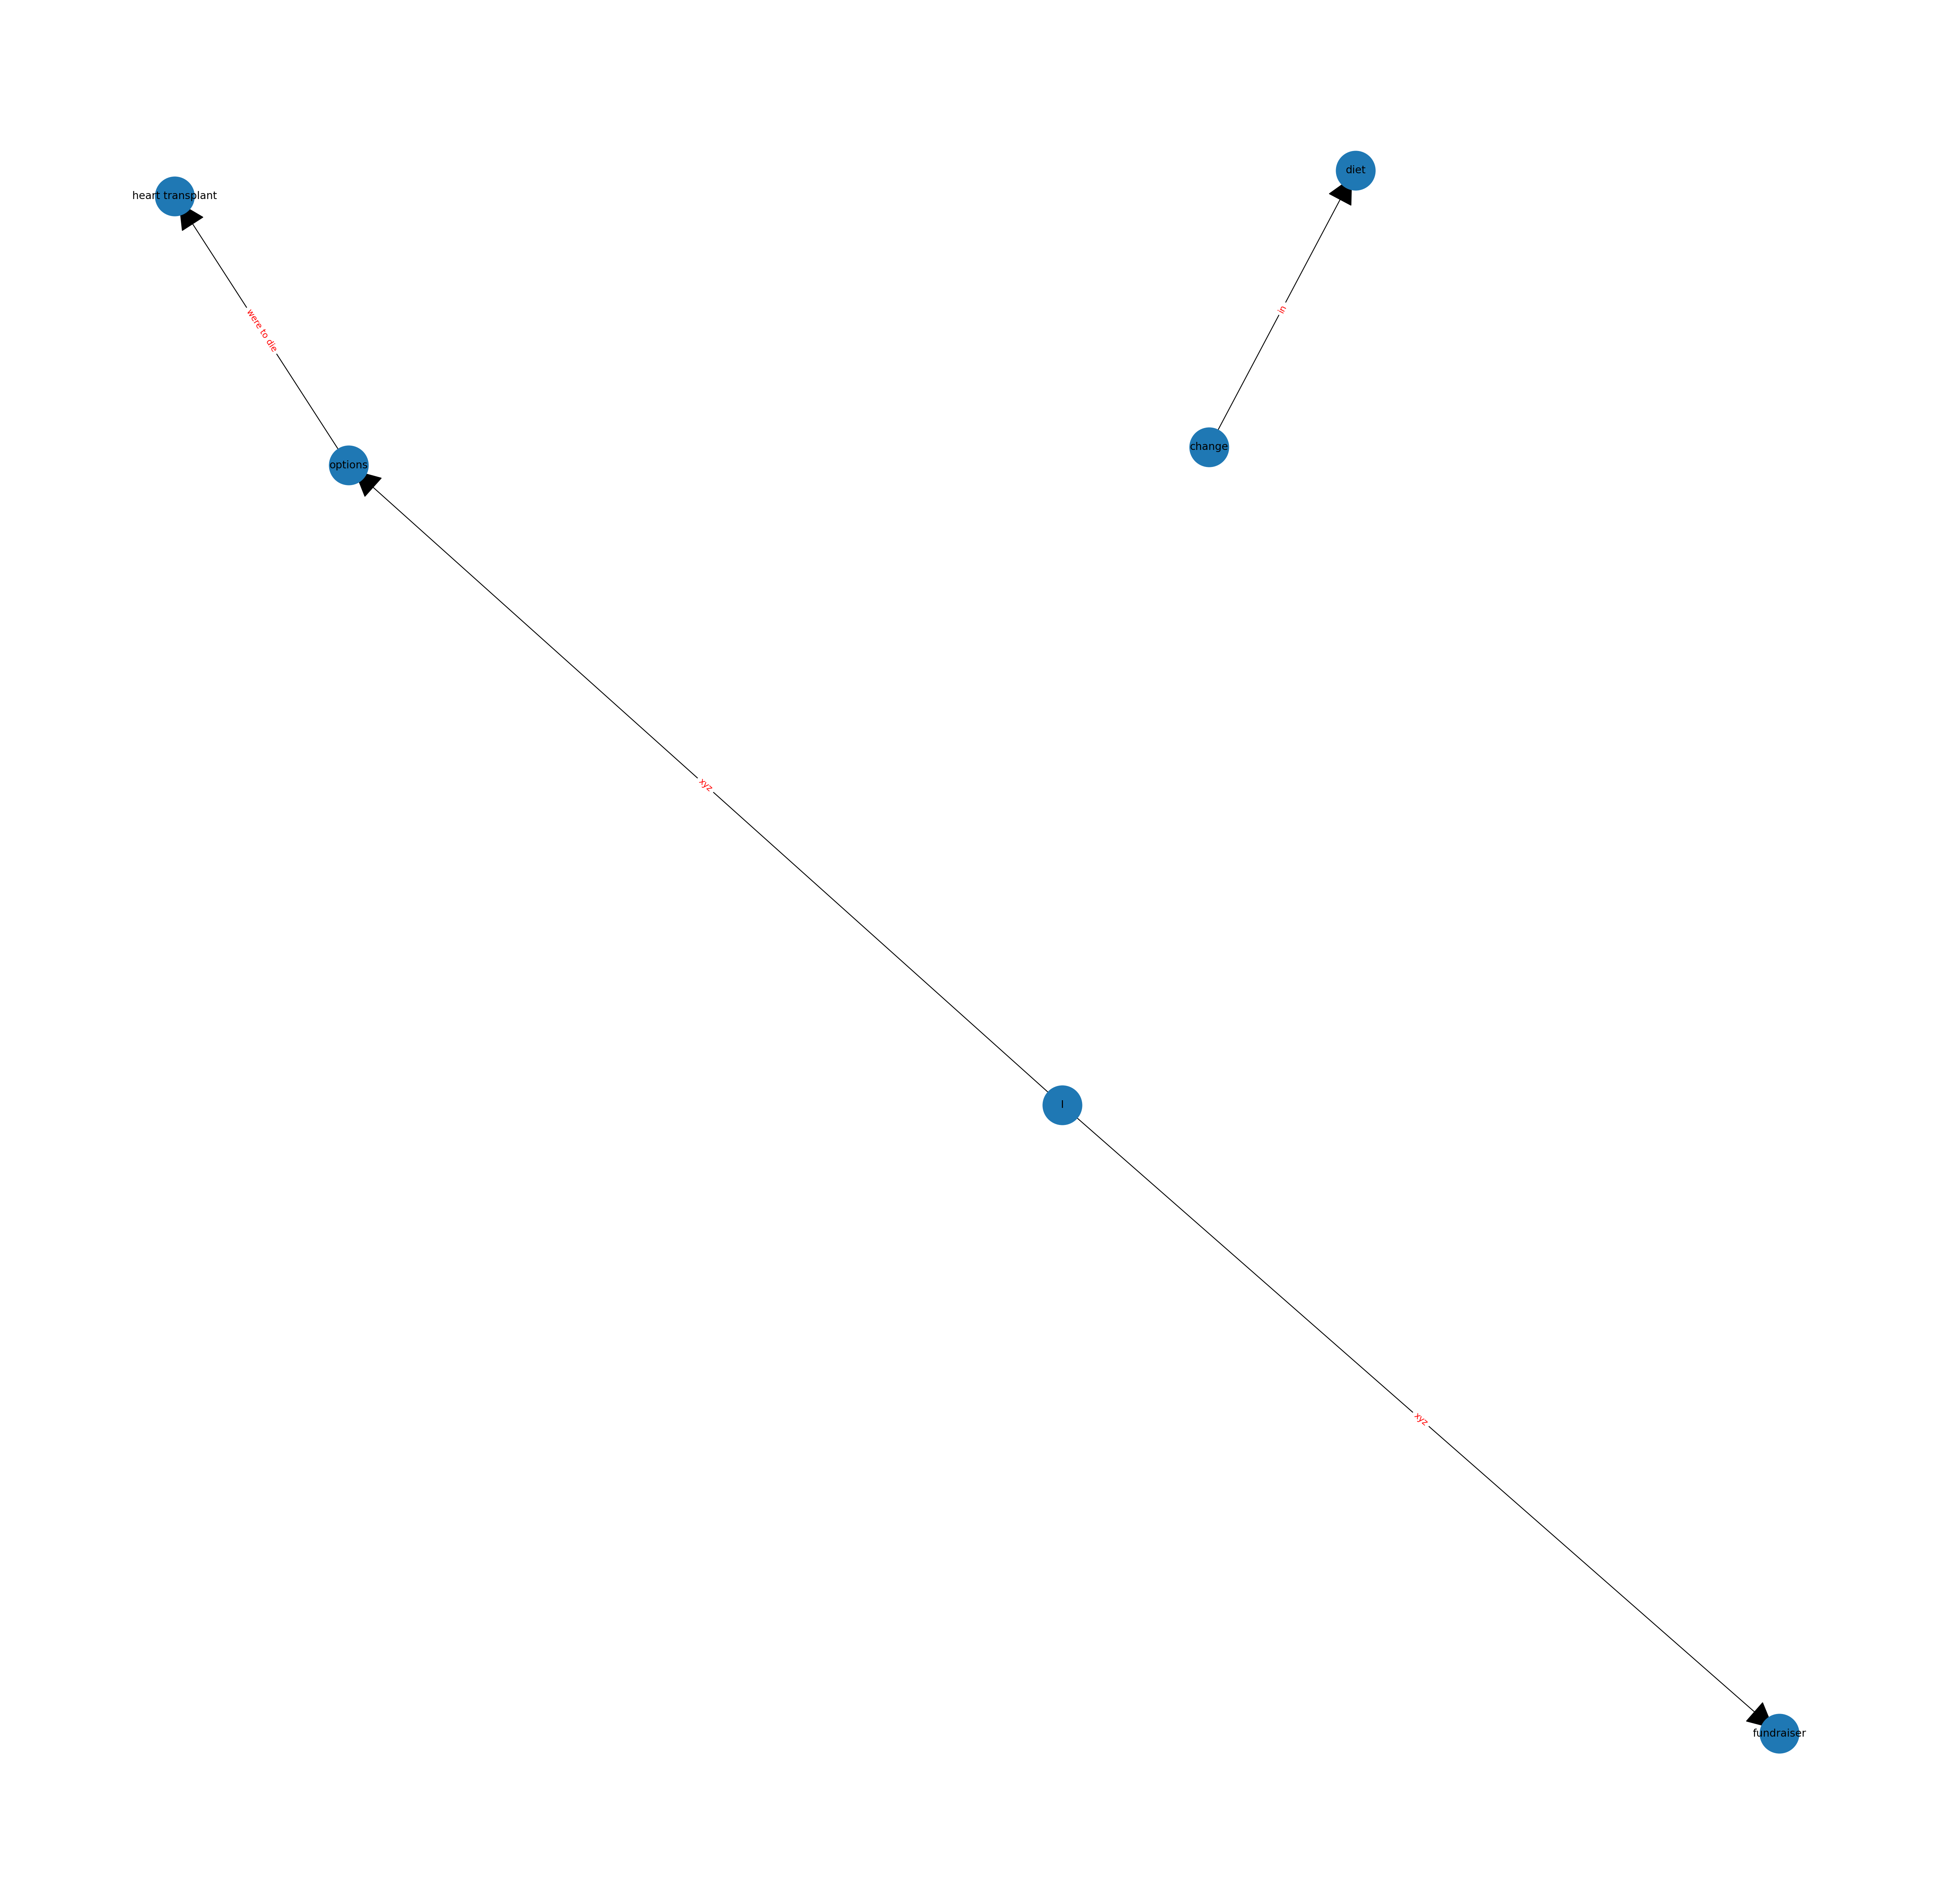

In [177]:
graph = G
error = False
plt.figure(num=None, figsize=(40,40), dpi=180)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph, pos, node_size=2000)
nx.draw_networkx_edges(graph, pos, arrowsize=70)
nx.draw_networkx_labels(graph, pos)
nx.draw_networkx_edge_labels(graph, pos, edge_labels=with_relation, font_color='red')
num_of_connected_comps = (list(nx.weakly_connected_components(G)))
print ("CALCULATING SCORES")
try:
    PR = nx.pagerank_numpy(G, alpha=0.9)
    DC = nx.degree_centrality(G)
    DB = nx.betweenness_centrality(G)
    print("GOT D SCORES", PR, DC, DB)
except PowerIterationFailedConvergence as e:
    print ("CONVERGENCE ERROR",e)
    error = True
plt.savefig('file_name', bbox_inches="tight")

In [178]:
sc = score_graph(fsid)
sc.calling_all_functions(output,with_relation,with_relation_with_pos,num_of_connected_comps)

TOTAL NODES {'change', 'options', 'diet', 'I', 'heart transplant', 'fundraiser'}
NODES WITH POS {'I': ['PRP'], 'options': ['NNS'], 'heart transplant': ['NN'], 'fundraiser': ['NN'], 'change': ['NN'], 'diet': ['NN']}
============================================================>>>>>
ORIGINAL-> CHF 4 1
ORIGINAL-> CHF 4 1
ORIGINAL-> 2018 6 1
ORIGINAL-> 2018 6 1
ORIGINAL-> heart transplant 14 1
ORIGINAL-> heart transplant 14 1
ORIGINAL-> heart pump 17 1
ORIGINAL-> heart pump 17 1
============================================================>>>>>
ORIGINAL-> CHF 4 2
ORIGINAL-> CHF 4 2
ORIGINAL-> 2018 6 2
ORIGINAL-> 2018 6 2
ORIGINAL-> heart transplant 14 2
ORIGINAL-> heart transplant 14 2
ORIGINAL-> heart pump 17 2
ORIGINAL-> heart pump 17 2
NON HUMAN ENTS-> ['heart pump', 'heart transplant', '2018', 'CHF']
HUMAN AND DATE ENTS-> []
TOTAL ENTS-> ['heart pump', 'heart transplant', '2018', 'CHF']
RAW ENTS-> ['CHF', '2018', 'heart transplant', 'heart pump', 'CHF', '2018', 'heart transplant', 'heart

{'status': 500,
 'body': "UNKNOW EXCEPTION IN CREATING QUALITY SCORE-> name 'connection' is not defined"}

In [123]:
# QUALITY SCORE-> 0.8642857142857143